# Choose the MSM lag-time
quick MSM to check what a sensible lag-time would be


In [3]:
from msmbuilder.feature_extraction import AlphaAngleFeaturizer
from msmbuilder.feature_selection import VarianceThreshold
from msmbuilder.preprocessing import RobustScaler
from msmbuilder.decomposition import tICA
from msmbuilder.cluster import MiniBatchKMedoids, MiniBatchKMeans
from msmbuilder.msm import MarkovStateModel
from msmbuilder.io import load_meta, preload_tops
from mdtraj import load
from sklearn.pipeline import Pipeline


In [25]:
from glob import glob

top = '/Users/robert_arbon/Google Drive/Research/Hyperparameter_Optimisation/Code/Data/Villin/top_prot.pdb'
traj_paths = glob('/Users/robert_arbon/Google Drive/Research/Hyperparameter_Optimisation/Code/Data/Villin/*.xtc')
stride=4
trajs = [load(traj, top=top, stride=stride) for traj in traj_paths]

In [61]:
ntimescales=5
to_ns=0.5*stride
steps = [('features', AlphaAngleFeaturizer()), 
        ('tica',  tICA(n_components=9, lag_time=int(22/to_ns), kinetic_mapping=True)), 
        ('cluster', MiniBatchKMedoids(n_clusters=654, random_state=42)), 
        ('msm', MarkovStateModel(n_timescales=ntimescales, lag_time=int(50/to_ns), verbose=True))]
pipe = Pipeline(steps)

In [62]:
import numpy as np
quantiles = np.arange(50, 101, 2)
ntimescales=5
timescales = np.zeros((quantiles.shape[0], ntimescales))
N = len(trajs)
for idx, quant in enumerate(quantiles):
    print(quant, end=', ')
    q = int(N/100*quant)
    pipe.fit(trajs[:q])
    timescales[idx] = pipe.named_steps['msm'].timescales_[:ntimescales]
    

50, MSM contains 1 strongly connected component above weight=0.04. Component 0 selected, with population 100.000000%
52, MSM contains 1 strongly connected component above weight=0.04. Component 0 selected, with population 100.000000%
54, MSM contains 1 strongly connected component above weight=0.04. Component 0 selected, with population 100.000000%
56, MSM contains 1 strongly connected component above weight=0.04. Component 0 selected, with population 100.000000%
58, MSM contains 1 strongly connected component above weight=0.04. Component 0 selected, with population 100.000000%
60, MSM contains 1 strongly connected component above weight=0.04. Component 0 selected, with population 100.000000%
62, MSM contains 1 strongly connected component above weight=0.04. Component 0 selected, with population 100.000000%
64, MSM contains 1 strongly connected component above weight=0.04. Component 0 selected, with population 100.000000%
66, MSM contains 1 strongly connected component above weight=0.0

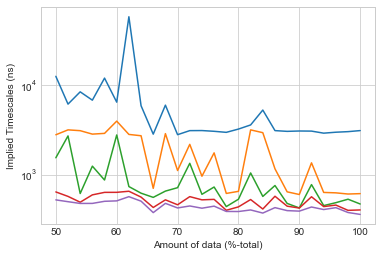

In [63]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
for i in range(ntimescales):
    plt.plot(quantiles, timescales.T[i]*to_ns)
    
plt.yscale('log')
plt.ylabel('Implied Timescales (ns)')
plt.xlabel('Amount of data (%-total)')


In [22]:
timescales*0.5

array([[ 3204.52804474,  1431.25048177,   300.09256354,   276.72498647,
          229.88201912],
       [ 7202.33745364,  1460.61818319,   846.33096269,   352.03950211,
          289.41391013],
       [ 1886.22821092,  1292.42414939,   317.34000927,   266.44925534,
          217.8024694 ],
       [ 2691.16783361,  1383.1091805 ,   321.82571623,   257.75429273,
          226.85805269],
       [ 4444.57722896,  1417.91507717,   283.49465061,   231.3858209 ,
          212.37429829],
       [ 1606.02505208,   992.67773926,   283.54581683,   215.33102319,
          211.95748201],
       [ 1584.01478982,   367.15827042,   277.56613879,   245.40314722,
          208.65949456],
       [ 1560.31314621,   524.95391254,   281.9390606 ,   197.64919227,
          178.78251396],
       [ 1524.16152053,   342.83859517,   286.1660533 ,   258.50633058,
          237.53798081],
       [ 1399.54913531,   337.9068375 ,   292.20206356,   208.10015247,
          196.12821927],
       [ 1534.71360844,   289.

In [28]:
model = pipe.named_steps['msm']

<Container object of 654 artists>

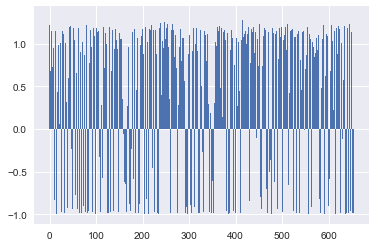

In [42]:
plt.bar(np.arange(model.n_states_), model.right_eigenvectors_[:,1], width=1)
# plt.ylim((-1,2))

In [44]:
# ntimescales=5
# to_ns=0.5*stride
# steps = [('features', AlphaAngleFeaturizer()), 
#         ('tica',  tICA(n_components=9, lag_time=int(22/to_ns), kinetic_mapping=True)), 
#         ('cluster', MiniBatchKMedoids(n_clusters=654, random_state=42)), 
#         ('msm', MarkovStateModel(n_timescales=ntimescales, lag_time=int(50/to_ns), verbose=True))]

Optimization terminated successfully.
         Current function value: -1.968712
         Iterations: 9
         Function evaluations: 26


In [27]:
ftrajs = AlphaAngleFeaturizer().fit_transform(trajs)

In [28]:
ttrajs = tICA(n_components=9, lag_time=int(22/to_ns), kinetic_mapping=True).fit_transform(ftrajs)

In [29]:
clusterer = MiniBatchKMedoids(n_clusters=654, random_state=42)
ctrajs = clusterer.fit_transform(ttrajs)

In [30]:
msm = MarkovStateModel(n_timescales=2, lag_time=int(50/to_ns))
msm.fit(ctrajs)

MSM contains 1 strongly connected component above weight=0.04. Component 0 selected, with population 100.000000%


MarkovStateModel(ergodic_cutoff='on', lag_time=25, n_timescales=2,
         prior_counts=0, reversible_type='mle', sliding_window=True,
         verbose=True)

In [31]:
import numpy as np
txx = np.concatenate(ttrajs)

In [32]:
from matplotlib import pyplot as plt
h, bx, by, = np.histogram2d(txx[:, 0], txx[:, 1], bins=1000)
f = -np.log(h)

/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


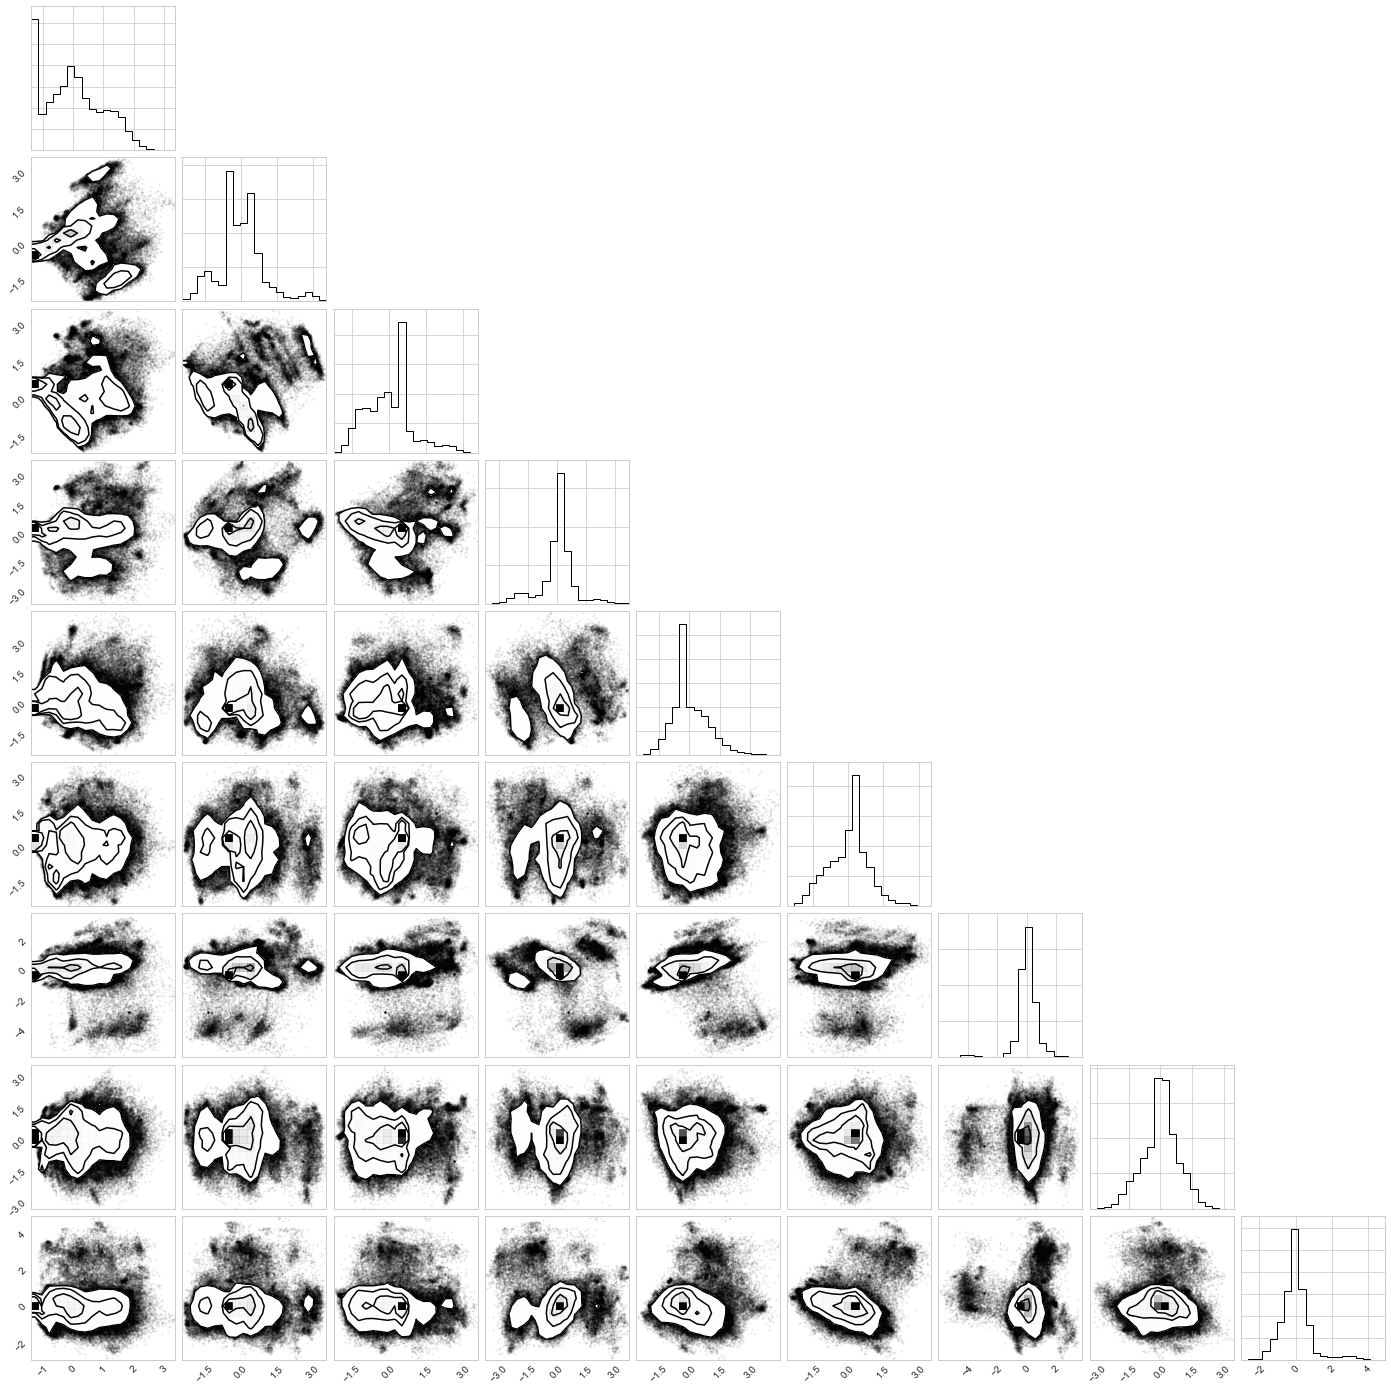

In [33]:
%matplotlib inline

import msmexplorer as msme
_ = msme.plot_histogram(txx)


In [58]:
from msmbuilder.lumping import PCCAPlus
pcca = PCCAPlus.from_msm(msm, n_macrostates=3)
macro_trajs = pcca.transform(ctrajs)

Optimization terminated successfully.
         Current function value: -2.831641
         Iterations: 22
         Function evaluations: 77


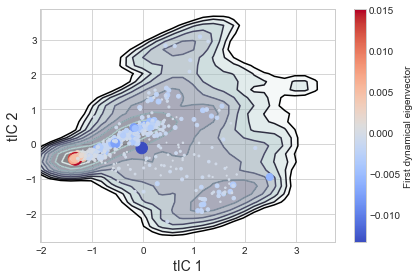

In [59]:
assignments = clusterer.partial_transform(txx)
assignments = msm.partial_transform(assignments)
msme.plot_free_energy(txx, obs=(0, 1), n_samples=10000,
                      pi=msm.populations_[assignments],
                      xlabel='tIC 1', ylabel='tIC 2')
plt.scatter(clusterer.cluster_centers_[msm.state_labels_, 0],
            clusterer.cluster_centers_[msm.state_labels_, 1],
            s=1e4 * msm.populations_,       # size by population
            c=msm.left_eigenvectors_[:, 1], # color by eigenvector
            cmap="coolwarm",
            zorder=3) 
plt.colorbar(label='First dynamical eigenvector')
plt.tight_layout()

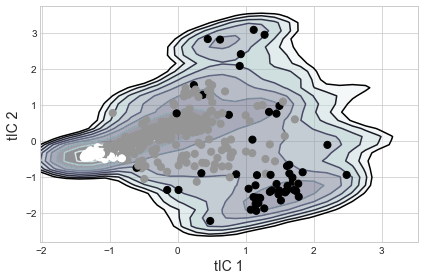

In [60]:
msme.plot_free_energy(txx, obs=(0, 1), n_samples=10000,
                      pi=msm.populations_[assignments],
                      xlabel='tIC 1', ylabel='tIC 2')
plt.scatter(clusterer.cluster_centers_[msm.state_labels_, 0],
            clusterer.cluster_centers_[msm.state_labels_, 1],
            s=50,
            c=pcca.microstate_mapping_,
            zorder=3
           )
plt.tight_layout()

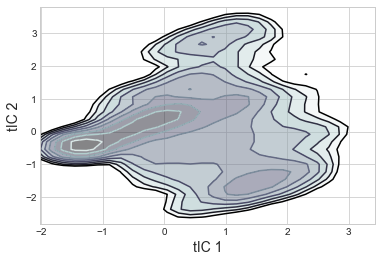

In [45]:
msme.plot_free_energy(txx, obs=(0, 1), n_samples=10000,
                      pi=msm.populations_[assignments],
                      xlabel='tIC 1', ylabel='tIC 2')

In [46]:
len(macro_trajs)

292

In [54]:
frames = [[], []]
states = [0,1]
for idx, mtraj in enumerate(macro_trajs):
    for state in states:
        ind = np.where(mtraj==state)[0]
        if len(ind) > 0: 
            frames[state].append((idx, np.random.choice(ind)))

In [55]:
frames

[[(0, 778),
  (1, 176),
  (2, 9),
  (3, 450),
  (4, 475),
  (5, 32),
  (6, 556),
  (7, 360),
  (8, 560),
  (9, 228),
  (10, 107),
  (11, 246),
  (12, 233),
  (13, 61),
  (14, 409),
  (15, 97),
  (16, 32),
  (17, 3),
  (18, 407),
  (19, 285),
  (20, 525),
  (21, 30),
  (22, 8),
  (23, 168),
  (24, 804),
  (25, 65),
  (26, 8),
  (27, 73),
  (28, 29),
  (29, 432),
  (30, 193),
  (31, 0),
  (32, 707),
  (33, 5),
  (34, 4),
  (35, 69),
  (36, 279),
  (37, 211),
  (38, 90),
  (39, 492),
  (40, 163),
  (41, 51),
  (42, 44),
  (43, 0),
  (44, 16),
  (45, 81),
  (46, 141),
  (47, 182),
  (48, 400),
  (49, 254),
  (50, 111),
  (51, 148),
  (52, 121),
  (53, 249),
  (54, 299),
  (55, 352),
  (56, 183),
  (57, 392),
  (58, 693),
  (59, 89),
  (60, 171),
  (61, 590),
  (62, 5),
  (63, 266),
  (64, 290),
  (65, 708),
  (66, 57),
  (67, 264),
  (68, 154),
  (69, 369),
  (70, 555),
  (71, 191),
  (72, 329),
  (73, 212),
  (74, 177),
  (75, 256),
  (76, 185),
  (77, 49),
  (78, 219),
  (79, 324),
  (80

In [57]:
import mdtraj as md
for idx, state in enumerate(frames):
    traj = md.join(
    md.load_frame(traj_paths[traj_i], index=frame_i, top=top)
    for traj_i, frame_i in state)
    traj.save('state-{}.xtc'.format(idx))